In [87]:
import json
import os.path as op
from os import sep
from utilities import files
import nibabel as nb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
from matplotlib_surface_plotting import plot_surf
from mne import read_epochs, pick_types
import scipy.ndimage as ndimage
from scipy.interpolate import interp2d, interp1d
from matplotlib import cm
from scipy.signal import savgol_filter

In [88]:
subj_idx=0
session_idxs=[0]
epo_type='motor'

# opening a json file
json_file="settings.json"
with open(json_file) as pipeline_file:
    parameters = json.load(pipeline_file)
        
if 'motor' in epo_type:
    # From BigBrain sample M1 location
    layer1_thickness=0.237 # mm
    layer23_thickness=0.926 # mm
    layer4_thickness=0
    layer5_thickness=0.763 # mm
    layer6_thickness=0.867 # mm
    total_thickness=layer1_thickness+layer23_thickness+layer4_thickness+layer5_thickness+layer6_thickness
    layer1_rel_thickness=layer1_thickness/total_thickness
    layer23_rel_thickness=layer23_thickness/total_thickness
    layer4_rel_thickness=layer4_thickness/total_thickness
    layer5_rel_thickness=layer5_thickness/total_thickness
    layer6_rel_thickness=layer6_thickness/total_thickness
elif 'visual' in epo_type:
    layer1_thickness=0.163 # mm
    layer23_thickness=0.702 # mm
    layer4_thickness=0.135 # mm
    layer5_thickness=0.562 # mm
    layer6_thickness=0.822 # mm
    total_thickness=layer1_thickness+layer23_thickness+layer4_thickness+layer5_thickness+layer6_thickness
    layer1_rel_thickness=layer1_thickness/total_thickness
    layer23_rel_thickness=layer23_thickness/total_thickness
    layer4_rel_thickness=layer4_thickness/total_thickness
    layer5_rel_thickness=layer5_thickness/total_thickness
    layer6_rel_thickness=layer6_thickness/total_thickness

In [89]:
path = parameters["dataset_path"]
der_path = op.join(path, "derivatives")
proc_path = op.join(der_path, "processed")

subjects = files.get_folders_files(proc_path)[0]
subjects.sort()

subject = subjects[subj_idx]
subject_id = subject.split("/")[-1]

sessions = files.get_folders(subject, 'ses', '')[2]
sessions.sort()

n_surfs=11

print("ID:", subject_id)
print("Epoch:", epo_type)

ID: sub-001
Epoch: motor


In [90]:
def compute_csd(surf_tcs, times, mean_dist, n_surfs):
    # Compute CSD
    nd=1;
    spacing=mean_dist*10**-3

    csd=np.zeros((n_surfs, surf_tcs.shape[1]))
    for t in range(surf_tcs.shape[1]):
        phi=surf_tcs[:,t]
        csd[0,t]=surf_tcs[0,t]
        csd[1,t]=surf_tcs[1,t]
        for z in range(2,n_surfs-3):
            csd[z,t]=(phi[z+2]-2*phi[z]+phi[z-2])/((nd*spacing)**2)
        csd[-2,t]=surf_tcs[-2,t]
        csd[-1,t]=surf_tcs[-1,t]            
    
    return csd

def smooth_csd(csd, n_surfs):
    # interpolate CSD in space
    y = np.linspace(0,n_surfs-1,n_surfs)
    Yi=np.linspace(0,n_surfs-1,500)
    
    f=interp1d(y,csd,kind='cubic',axis=0)
    csd_smooth=f(Yi)
    
    csd_smooth=savgol_filter(csd_smooth, 51, 3, axis=1)
    
    return csd_smooth

In [98]:
def plot_csd(csd, times, n_surfs, ax, vmin=None, vmax=None, plot_boundaries=True):
    if vmin is None:
        vmin=-np.max(np.abs(csd[:]))
    if vmax is None:
        vmax=np.max(np.abs(csd[:]))
    divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    levels=np.linspace(vmin,vmax,100)
    im=ax.contourf(csd,cmap='RdBu_r', levels=levels, vmin=vmin, vmax=vmax,
             extent=[times[0], times[-1], 0, n_surfs-1], origin='lower', norm=divnorm, extend='both')
    yticks=ax.get_yticks()
    ax.set_yticks(range(n_surfs,-1,-1))
    ax.set_ylim([n_surfs-1,0])
    
    if plot_boundaries:
        layer1_boundary=(n_surfs-1)*layer1_rel_thickness
        ax.plot([times[0], times[-1]],[layer1_boundary, layer1_boundary],'k--')
        ax.text(times[-1]+.02, layer1_boundary, 'I')

        layer23_boundary=layer1_boundary+(n_surfs-1)*layer23_rel_thickness
        ax.plot([times[0], times[-1]],[layer23_boundary, layer23_boundary],'k--')
        ax.text(times[-1]+.02, layer1_boundary+.5*(layer23_boundary-layer1_boundary), 'II/III')

        layer4_boundary=layer23_boundary+(n_surfs-1)*layer4_rel_thickness
        if layer4_rel_thickness>0:
            ax.plot([times[0], times[-1]],[layer4_boundary, layer4_boundary],'k--')
            ax.text(times[-1]+.02, layer23_boundary+.5*(layer4_boundary-layer23_boundary), 'IV')

        layer5_boundary=layer4_boundary+(n_surfs-1)*layer5_rel_thickness
        ax.plot([times[0], times[-1]],[layer5_boundary, layer5_boundary],'k--')
        ax.text(times[-1]+.02, layer4_boundary+.5*(layer5_boundary-layer4_boundary), 'V')

        layer6_boundary=layer5_boundary+(n_surfs-1)*layer6_rel_thickness
        ax.text(times[-1]+.02, layer5_boundary+.5*(layer6_boundary-layer5_boundary), 'VI')
    
    ax.plot([0, 0], [0,10],'--',color='grey')
    ax.set_xlim([times[0], times[-1]])
    for yidx,ytick in enumerate(ax.get_yticklabels()):
        ytick.set_color(cool_colors[yidx-1])
    ax.set_ylabel('surface')
    ax.set_xlabel('time (s)')
    #cb=plt.colorbar(im, ax=ax, pad=0.1)
#     cb.set_ticks([])

In [131]:
def nan_basic_interp(array):
    nans, ix = np.isnan(array), lambda x: x.nonzero()[0]
    array[nans] = np.interp(ix(nans), ix(~nans), array[~nans])
    return array

Session: ses-01
Run: 001
Pial coord=[-16.93147278   6.32237673  45.31126022]
Inter-surface distances=[0.22238452 0.22281951 0.22275697 0.22267899 0.2226498  0.22266805
 0.22266443 0.22265408 0.22266443 0.22267718]
Mean distance=0.22266179680230058
Run: 002
Pial coord=[-16.93147278   6.32237673  45.31126022]
Inter-surface distances=[0.22238452 0.22281951 0.22275697 0.22267899 0.2226498  0.22266805
 0.22266443 0.22265408 0.22266443 0.22267718]
Mean distance=0.22266179680230058
Run: 003
Pial coord=[-16.93147278   6.32237673  45.31126022]
Inter-surface distances=[0.22238452 0.22281951 0.22275697 0.22267899 0.2226498  0.22266805
 0.22266443 0.22265408 0.22266443 0.22267718]
Mean distance=0.22266179680230058


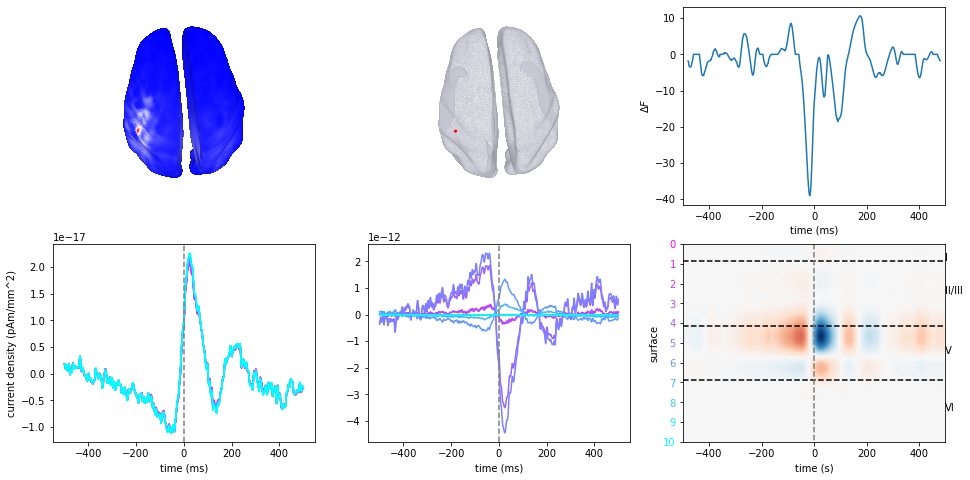

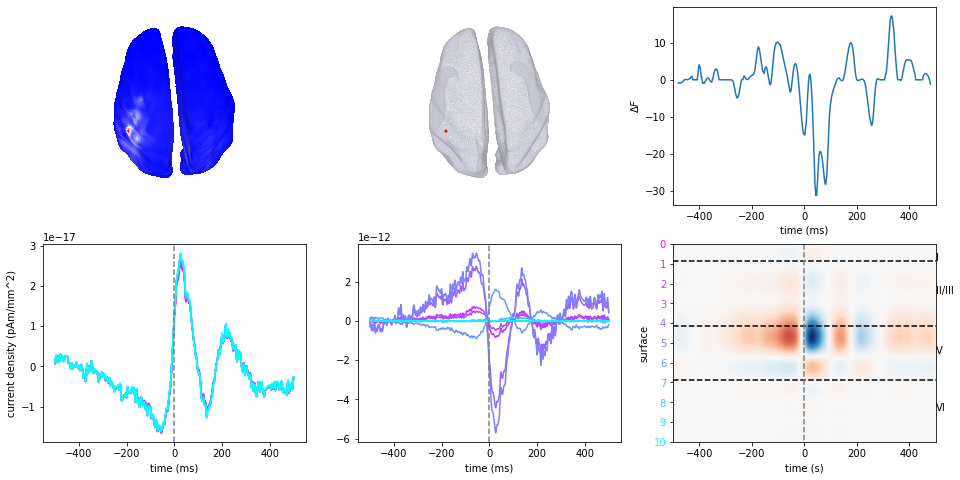

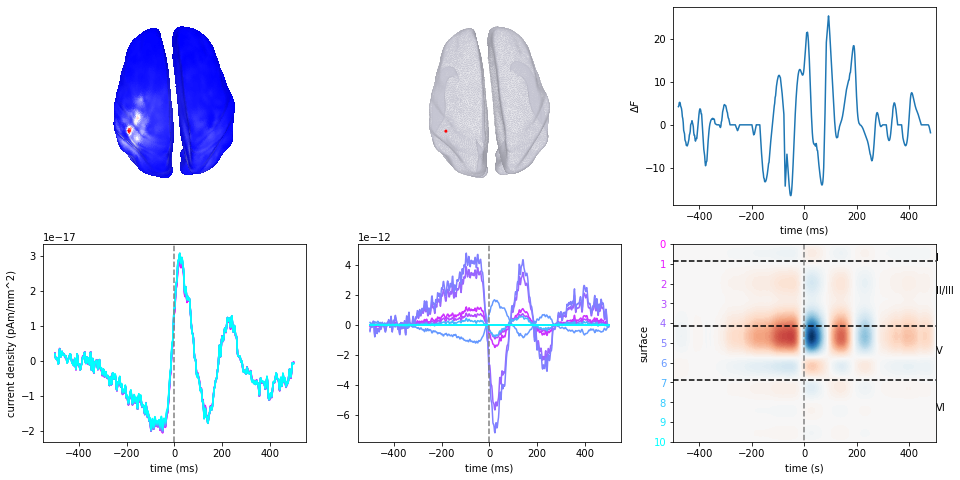

In [133]:
for session_idx in session_idxs:
    session=sessions[session_idx]
    session_id = session.split("/")[-1]

    res_fnames = files.get_files(op.join(session, 'spm'), "invert_fmspm_converted_autoreject", epo_type + "-epo_multilayer_results.json")[2]
    res_fnames.sort()
    print("Session:", session_id)
    
    for run_idx in range(3):
        res_fname=res_fnames[run_idx]

        numero = res_fname.split(sep)[-1].split("-")[5]

        with open(res_fname) as results_file:
            results = json.load(results_file)                    

        print("Run:", numero)
        
        localizer_fname=op.join(session, 'spm', 'invert_fmspm_converted_autoreject-{}-{}-{}-{}-epo_localizer_results.json'.format(subject_id,session_id,numero,epo_type))
        with open(localizer_fname) as localizer_file:
            localizer = json.load(localizer_file)
            
        fe_tc_fname=op.join(session, 'spm', 'invert_fmspm_converted_autoreject-{}-{}-{}-{}-epo_tc_results.json'.format(subject_id,session_id,numero,epo_type))
        with open(fe_tc_fname) as fe_tc_file:
            fe_tc = json.load(fe_tc_file)
        f_diff=np.array(fe_tc['f_diff'])
        sec_der = np.insert(np.diff(np.insert(np.diff(f_diff), 0, 0)), 0, 0)
        f_diff[np.abs(sec_der) > 1] = np.nan
        f_diff = nan_basic_interp(f_diff)
        
        # Load multilayer surface
        multilayer_surf=nb.load(results['surf_fname']);
        multilayer_vertices, multilayer_faces = multilayer_surf.darrays[0].data, multilayer_surf.darrays[1].data

        # Load pial surface
        pial_surf_fname = op.join(sep.join(results['surf_fname'].split(sep)[0:-1]), 'pial.ds.inflated.nodeep.gii')
        pial_surf=nb.load(pial_surf_fname);
        pial_vertices, pial_faces = pial_surf.darrays[0].data, pial_surf.darrays[1].data

        # Load inversion results and MU matrix
        res = pd.read_csv(results['res_fname'], sep="\t", header=None).values
        MU=pd.read_csv(results['mu_fname'], sep="\t", header=None).values

        n_vertices_per_surf=int(res.shape[0]/n_surfs)

        # Average over surfaces
        surf_averaged=np.zeros(n_vertices_per_surf)
        for i in range(n_surfs):
            surf_averaged=surf_averaged+res[i*n_vertices_per_surf:(i+1)*n_vertices_per_surf,0]
        surf_averaged=surf_averaged/n_surfs

        # Get the peak index
#         peak_idx=np.argmax(surf_averaged)
        peak_idx=localizer['peak_idx']
        
        # Check surface spacing
        peak_coord=np.zeros((n_surfs,3))
        for i in range(n_surfs):
            peak_coord[i,:]=multilayer_vertices[i*n_vertices_per_surf+peak_idx,:]
        print('Pial coord={}'.format(peak_coord[-1,:]))
        dists=np.sqrt(np.sum((peak_coord[1:,:]-peak_coord[0:-1,:])**2,axis=1))
        print('Inter-surface distances={}'.format(dists))
        mean_dist=np.mean(dists)
        print('Mean distance={}'.format(mean_dist))

        # Load data
        epo_path = op.join(session, 'autoreject-' + subject_id + "-" + session_id + "-" + numero + "-" + epo_type + "-epo.fif")
        epochs = read_epochs(epo_path, verbose=False, preload=True)
        #epochs = epochs.filter(0,30)
        meg_chans=pick_types(epochs.info,meg=True, ref_meg=False)
        epo_data=epochs.get_data()
        epo_data=epo_data[:,meg_chans,:]

        # Average over trials
        evoked=np.mean(epo_data,axis=0)
        # Get source time course in each surface
        surf_tcs=np.zeros((n_surfs, evoked.shape[1]))
        for i in range(n_surfs):
            surf_peak_idx=i*n_vertices_per_surf+peak_idx
            surf_tcs[n_surfs-i-1,:]=np.matmul(MU[surf_peak_idx,:].reshape(1,-1),evoked)

        csd=compute_csd(surf_tcs, epochs.times, mean_dist, n_surfs)
        csd_smooth=smooth_csd(csd, n_surfs)
        
        rotate = [90]
        x_rotate = 270
        if 'motor' in epo_type:
            rotate = [0]
            x_rotate = 0
        elif 'visual' in epo_type:
            rotate = [0]
            x_rotate = -90
        fig = plt.figure(figsize=(16,8), facecolor='white')
        cool_colors = plt.cm.cool(np.linspace(0,1,n_surfs))

        # Plot inversion result
        ax = plt.subplot(2, 3, 1, xlim=[-.98, +.98], ylim=[-.98, +.98],
                         aspect=1, frameon=False,
                         xticks=[], yticks=[])
        thresh=np.percentile(surf_averaged,95)
        plot_surf(vertices=pial_vertices, faces=pial_faces, overlay=surf_averaged, rotate=rotate, x_rotate=x_rotate,
                  ax=ax, colorbar=False, cmap='bwr')#, alpha_colour=(surf_averaged > thresh).astype(int))


        ax = plt.subplot(2, 3, 2, xlim=[-.98, +.98], ylim=[-.98, +.98],
                         aspect=1, frameon=False,
                         xticks=[], yticks=[])
        overlay = np.zeros(surf_averaged.shape)
        overlay[0] = 10
        plot_surf(vertices=pial_vertices, faces=pial_faces, overlay=overlay, rotate=rotate, x_rotate=x_rotate,
                  ax=ax, colorbar=False, cmap='jet', alpha_colour=(overlay > 0).astype(int), vmin=0, vmax=4,
                  transparency=.25, coords=[pial_vertices[peak_idx,:]], coord_size=0.01)
        
        ax = plt.subplot(2, 3, 3)
        inner_times = fe_tc['times'][fe_tc['left_idx'] - 1:fe_tc['right_idx']]        
        plt.plot(inner_times, f_diff)
        plt.xlim([epochs.times[0]*1000,epochs.times[-1]*1000])
        plt.xlabel('time (ms)')
        plt.ylabel(r'$\Delta F$')
        

        ax = plt.subplot(2, 3, 4)
        for i in range(n_surfs):
            ax.plot(epochs.times*1000,surf_tcs[i,:],color=cool_colors[n_surfs-i-1], label='{}'.format(i))
        yl=ax.get_ylim()
        ax.plot([0, 0], yl,'--',color='grey')
        ax.set_ylim(yl)
        ax.set_xlabel('time (ms)')
        ax.set_ylabel('current density (pAm/mm^2)')

        ax = plt.subplot(2, 3, 5)
        for i in range(n_surfs):
            ax.plot(epochs.times*1000,csd[i,:],color=cool_colors[n_surfs-i-1], label='{}'.format(i))
        yl=ax.get_ylim()
        ax.plot([0, 0], yl,'--',color='grey')
        ax.set_ylim(yl)
        ax.set_xlabel('time (ms)')

        ax = plt.subplot(2, 3, 6)
        plot_csd(csd_smooth, epochs.times*1000, n_surfs, ax, plot_boundaries=True)

        fig.savefig('{}_{}_{}_{}_csd.png'.format(subject_id, session_id, numero, epo_type))

#         beh_path = op.join(session, 'autoreject-' + subject_id + "-" + session_id + "-" + numero + "-" + epo_type + "-beh.csv")
#         beh=pd.read_csv(beh_path)

#         coh=['low','med','high']
#         cond_csd_smooths=[]

#         fig = plt.figure(figsize=(16,4))
#         zls=[]
#         for coh_idx, coh_level in enumerate(coh):
#             trial_idx=beh.index[beh['trial_coherence']==coh_level].tolist()
#             print(len(trial_idx))
#             # Average over trials
#             cond_evoked=np.mean(epo_data[trial_idx,:,:],axis=0)
#             # Get source time course in each surface
#             cond_surf_tcs=np.zeros((n_surfs, cond_evoked.shape[1]))
#             for i in range(n_surfs):
#                 surf_peak_idx=i*n_vertices_per_surf+peak_idx
#                 cond_surf_tcs[n_surfs-i-1,:]=np.matmul(MU[surf_peak_idx,:].reshape(1,-1),cond_evoked)

#             # Compute CSD
#             (cond_csd,cond_csd_smooth)=compute_csd(cond_surf_tcs, epochs.times, mean_dist, n_surfs)

#             cond_csd_smooths.append(cond_csd_smooth)
#             zls.append([np.min(cond_csd_smooth[:]), np.max(cond_csd_smooth[:])])

#         zls=np.array(zls)
#         zl=[np.min(zls[:,0]), np.max(zls[:,1])]

#         for coh_idx, coh_level in enumerate(coh):
#             ax = plt.subplot(1, len(coh), coh_idx+1)
#             plot_csd(cond_csd_smooths[coh_idx], epochs.times, n_surfs, ax, vmin=zl[0], vmax=zl[1])    
#             ax.set_title('coh={}'.format(coh_level))

#         fig = plt.figure(figsize=(10,4))
#         low_med_csd=cond_csd_smooths[0]-cond_csd_smooths[1]
#         high_med_csd=cond_csd_smooths[2]-cond_csd_smooths[1]
#         zl=[np.min([np.min(low_med_csd[:]), np.min(high_med_csd[:])]), np.max([np.max(low_med_csd[:]), np.max(high_med_csd[:])])]
#         ax = plt.subplot(1, 2, 1)
#         plot_csd(low_med_csd, epochs.times, n_surfs, ax, vmin=zl[0], vmax=zl[1])    
#         ax.set_title('low-med')
#         ax = plt.subplot(1, 2, 2)
#         plot_csd(high_med_csd, epochs.times, n_surfs, ax, vmin=zl[0], vmax=zl[1])    
#         ax.set_title('high-med')

#         cong=['congruent','incongruent']
#         cond_csd_smooths=[]

#         fig = plt.figure(figsize=(8,4))
#         zls=[]
#         for cong_idx, cong_level in enumerate(cong):
#             trial_idx=beh.index[beh['trial_congruence']==cong_level].tolist()
#             print(len(trial_idx))
#             # Average over trials
#             cond_evoked=np.mean(epo_data[trial_idx,:,:],axis=0)
#             # Get source time course in each surface
#             cond_surf_tcs=np.zeros((n_surfs, cond_evoked.shape[1]))
#             for i in range(n_surfs):
#                 surf_peak_idx=i*n_vertices_per_surf+peak_idx
#                 cond_surf_tcs[n_surfs-i-1,:]=np.matmul(MU[surf_peak_idx,:].reshape(1,-1),cond_evoked)

#             # Compute CSD
#             (cond_csd,cond_csd_smooth)=compute_csd(cond_surf_tcs, epochs.times, mean_dist, n_surfs)

#             cond_csd_smooths.append(cond_csd_smooth)
#             zls.append([np.min(cond_csd_smooth[:]), np.max(cond_csd_smooth[:])])

#         zls=np.array(zls)
#         zl=[np.min(zls[:,0]), np.max(zls[:,1])]

#         for cong_idx, cong_level in enumerate(cong):
#             ax = plt.subplot(1, len(cong), cong_idx+1)
#             plot_csd(cond_csd_smooths[cong_idx], epochs.times, n_surfs, ax, vmin=zl[0], vmax=zl[1])    
#             ax.set_title(cong_level)

#         fig = plt.figure(figsize=(4,4))
#         cong_incong_csd=cond_csd_smooths[0]-cond_csd_smooths[1]
#         ax = plt.subplot(1, 1, 1)
#         plot_csd(cong_incong_csd, epochs.times, n_surfs, ax)    
#         ax.set_title('congruent-incongruent')


Session: ses-03
Run: 001
Pial coord=[-47.27190018   1.46280682  59.42686844]
Inter-surface distances=[0.23901537 0.23827158 0.23856127 0.23860247 0.23860587 0.2386137
 0.23861116 0.2386137  0.23861412 0.23861508]
Mean distance=0.2386124300604696
Run: 002
Pial coord=[-11.78707409 -25.58098602  53.0266571 ]
Inter-surface distances=[0.27287761 0.27376509 0.27342777 0.27336179 0.27335865 0.27336517
 0.27335852 0.27336517 0.27335483 0.27336885]
Mean distance=0.2733603436865234
Run: 003
Pial coord=[-12.27633667  -4.75804138  47.06718445]
Inter-surface distances=[0.35194012 0.35219692 0.35229379 0.35220019 0.35216164 0.35216185
 0.35215708 0.35215613 0.35216185 0.35216736]
Mean distance=0.3521596911021844


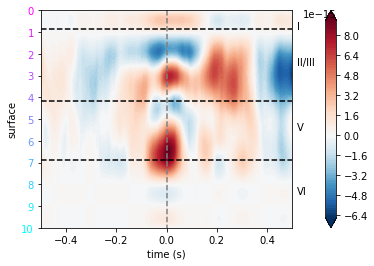

In [7]:
random_csds=[]
n_shufs=1000;
for session_idx in session_idxs:
    session=sessions[session_idx]
    session_id = session.split("/")[-1]

    res_fnames = files.get_files(op.join(session, 'spm'), "invert_fmspm_converted_autoreject", epo_type + "-epo_multilayer_results.json")[2]
    res_fnames.sort()
    print("Session:", session_id)
    
    for run_idx in range(3):
        res_fname=res_fnames[run_idx]

        numero = res_fname.split(sep)[-1].split("-")[5]

        with open(res_fname) as results_file:
            results = json.load(results_file)

        print("Run:", numero)

        # Load multilayer surface
        multilayer_surf=nb.load(results['surf_fname']);
        multilayer_vertices, multilayer_faces = multilayer_surf.darrays[0].data, multilayer_surf.darrays[1].data

        # Load pial surface
        pial_surf_fname = op.join(sep.join(results['surf_fname'].split(sep)[0:-1]), 'pial.ds.inflated.nodeep.gii')
        pial_surf=nb.load(pial_surf_fname);
        pial_vertices, pial_faces = pial_surf.darrays[0].data, pial_surf.darrays[1].data

        # Load inversion results and MU matrix
        res = pd.read_csv(results['res_fname'], sep="\t", header=None).values
        MU=pd.read_csv(results['mu_fname'], sep="\t", header=None).values

        n_vertices_per_surf=int(res.shape[0]/n_surfs)

        # Average over surfaces
        surf_averaged=np.zeros(n_vertices_per_surf)
        for i in range(n_surfs):
            surf_averaged=surf_averaged+res[i*n_vertices_per_surf:(i+1)*n_vertices_per_surf,0]
        surf_averaged=surf_averaged/n_surfs

        # Check surface spacing
        peak_coord=np.zeros((n_surfs,3))
        for i in range(n_surfs):
            peak_coord[i,:]=multilayer_vertices[i*n_vertices_per_surf+peak_idx,:]
        print('Pial coord={}'.format(peak_coord[-1,:]))
        dists=np.sqrt(np.sum((peak_coord[1:,:]-peak_coord[0:-1,:])**2,axis=1))
        print('Inter-surface distances={}'.format(dists))
        mean_dist=np.mean(dists)
        print('Mean distance={}'.format(mean_dist))

        # Load data
        epo_path = op.join(session, 'autoreject-' + subject_id + "-" + session_id + "-" + numero + "-" + epo_type + "-epo.fif")
        epochs = read_epochs(epo_path, verbose=False, preload=True)
        #epochs = epochs.filter(0,30)
        meg_chans=pick_types(epochs.info,meg=True, ref_meg=False)
        epo_data=epochs.get_data()
        epo_data=epo_data[:,meg_chans,:]

        # Average over trials
        evoked=np.mean(epo_data,axis=0)
        
        for shuf_idx in range(n_shufs):
            # Get the peak index
            peak_idx=np.random.choice(n_vertices_per_surf)

            # Get source time course in each surface
            surf_tcs=np.zeros((n_surfs, evoked.shape[1]))
            for i in range(n_surfs):
                surf_peak_idx=i*n_vertices_per_surf+peak_idx
                surf_tcs[n_surfs-i-1,:]=np.matmul(MU[surf_peak_idx,:].reshape(1,-1),evoked)

            (csd,csd_smooth)=compute_csd(surf_tcs, epochs.times, mean_dist, n_surfs)
            random_csds.append(csd_smooth)
random_csds=np.mean(np.array(random_csds),axis=0)
fig=plt.figure()
ax = plt.subplot(1, 1, 1)
plot_csd(random_csds, epochs.times, n_surfs, ax, plot_boundaries=True)

In [8]:
# MU=[]
# res=[]
# for run_idx in range(3):
#     res_fname=res_fnames[run_idx]

#     numero = res_fname.split(sep)[-1].split("-")[5]

#     with open(res_fname) as results_file:
#         results = json.load(results_file)

#     print("Run:", numero)
    
#     # Load multilayer surface
#     multilayer_surf=nb.load(results['surf_fname']);
#     multilayer_vertices, multilayer_faces = multilayer_surf.darrays[0].data, multilayer_surf.darrays[1].data

#     # Load pial surface
#     pial_surf_fname = op.join(sep.join(results['surf_fname'].split(sep)[0:-1]), 'pial.ds.inflated.nodeep.gii')
#     pial_surf=nb.load(pial_surf_fname);
#     pial_vertices, pial_faces = pial_surf.darrays[0].data, pial_surf.darrays[1].data

#     # Load inversion results and MU matrix
#     rres = pd.read_csv(results['res_fname'], sep="\t", header=None).values
#     rMU=pd.read_csv(results['mu_fname'], sep="\t", header=None).values
    
#     MU.append(rMU)
#     res.append(rres)
# MU=np.array(MU)
# MU=np.mean(MU,axis=0)
# res=np.array(res)
# res=np.mean(res,axis=0)
    

In [9]:
# n_vertices_per_surf=int(res.shape[0]/n_surfs)
    
# # Average over surfaces
# surf_averaged=np.zeros(n_vertices_per_surf)
# for i in range(n_surfs):
#     surf_averaged=surf_averaged+res[i*n_vertices_per_surf:(i+1)*n_vertices_per_surf,0]
# surf_averaged=surf_averaged/n_surfs

# # Get the peak index
# peak_idx=np.argmax(surf_averaged)
    
# # Check surface spacing
# peak_coord=np.zeros((n_surfs,3))
# for i in range(n_surfs):
#     peak_coord[i,:]=multilayer_vertices[i*n_vertices_per_surf+peak_idx,:]
# print('Pial coord={}'.format(peak_coord[-1,:]))
# dists=np.sqrt(np.sum((peak_coord[1:,:]-peak_coord[0:-1,:])**2,axis=1))
# print('Inter-surface distances={}'.format(dists))
# mean_dist=np.mean(dists)
# print('Mean distance={}'.format(mean_dist))

In [10]:
# all_epo_data=[]
# for run_idx in range(3):
#     res_fname=res_fnames[run_idx]
#     numero = res_fname.split(sep)[-1].split("-")[5]

#     # Load data
#     epo_path = op.join(session, 'autoreject-' + subject_id + "-" + session_id + "-" + numero + "-" + epo_type + "-epo.fif")
#     epochs = read_epochs(epo_path, verbose=False, preload=True)
#     #epochs = epochs.filter(0,30)
#     meg_chans=pick_types(epochs.info,meg=True, ref_meg=False)
#     epo_data=epochs.get_data()
#     epo_data=epo_data[:,meg_chans,:]
#     all_epo_data.append(epo_data)
# all_epo_data=np.concatenate(all_epo_data,axis=0)

In [11]:
# # Average over trials
# evoked=np.mean(all_epo_data,axis=0)
# # Get source time course in each surface
# surf_tcs=np.zeros((n_surfs, evoked.shape[1]))
# for i in range(n_surfs):
#     surf_peak_idx=i*n_vertices_per_surf+peak_idx
#     surf_tcs[n_surfs-i-1,:]=np.matmul(MU[surf_peak_idx,:].reshape(1,-1),evoked)

# (csd,csd_smooth)=compute_csd(surf_tcs, epochs.times, mean_dist, n_surfs)

# rotate = [90]
# x_rotate = 270
# if 'motor' in epo_type:
#     rotate = [0]
#     x_rotate = 0
# elif 'visual' in epo_type:
#     rotate = [0]
#     x_rotate = -90
# fig = plt.figure(figsize=(16,8), facecolor='white')
# cool_colors = plt.cm.cool(np.linspace(0,1,n_surfs))

# # Plot inversion result
# ax = plt.subplot(2, 3, 1, xlim=[-.98, +.98], ylim=[-.98, +.98],
#                  aspect=1, frameon=False,
#                  xticks=[], yticks=[])
# thresh=np.percentile(surf_averaged,95)
# plot_surf(vertices=pial_vertices, faces=pial_faces, overlay=surf_averaged, rotate=rotate, x_rotate=x_rotate,
#           ax=ax, colorbar=False, cmap='bwr')#, alpha_colour=(surf_averaged > thresh).astype(int))


# ax = plt.subplot(2, 3, 2, xlim=[-.98, +.98], ylim=[-.98, +.98],
#                  aspect=1, frameon=False,
#                  xticks=[], yticks=[])
# overlay = np.zeros(surf_averaged.shape)
# overlay[0] = 10
# plot_surf(vertices=pial_vertices, faces=pial_faces, overlay=overlay, rotate=rotate, x_rotate=x_rotate,
#           ax=ax, colorbar=False, cmap='jet', alpha_colour=(overlay > 0).astype(int), vmin=0, vmax=4,
#           transparency=.25, coords=[pial_vertices[peak_idx,:]], coord_size=0.01)

# ax = plt.subplot(2, 3, 4)
# for i in range(n_surfs):
#     ax.plot(epochs.times,surf_tcs[i,:],color=cool_colors[n_surfs-i-1], label='{}'.format(i))
# yl=ax.get_ylim()
# ax.plot([0, 0], yl,'--',color='grey')
# ax.set_ylim(yl)
# ax.set_xlabel('time (s)')
# ax.set_ylabel('current density (pAm/mm^2)')

# ax = plt.subplot(2, 3, 5)
# for i in range(n_surfs):
#     ax.plot(epochs.times,csd[i,:],color=cool_colors[n_surfs-i-1], label='{}'.format(i))
# yl=ax.get_ylim()
# ax.plot([0, 0], yl,'--',color='grey')
# ax.set_ylim(yl)
# ax.set_xlabel('time (s)')

# ax = plt.subplot(2, 3, 6)
# csd_smooth[(~np.isfinite(csd_smooth[:]))]=0
# plot_csd(csd_smooth, epochs.times, n_surfs, ax, plot_boundaries=True)

In [12]:
# behs=[]
# for run_idx in range(3):
#     res_fname=res_fnames[run_idx]
#     numero = res_fname.split(sep)[-1].split("-")[5]
#     beh_path = op.join(session, 'autoreject-' + subject_id + "-" + session_id + "-" + numero + "-" + epo_type + "-beh.csv")
#     behs.append(pd.read_csv(beh_path))
# beh = pd.concat(behs)

In [13]:
# coh=['low','med','high']
# cond_csd_smooths=[]

# fig = plt.figure(figsize=(16,4))
# zls=[]
# for coh_idx, coh_level in enumerate(coh):
#     trial_idx=beh.index[beh['trial_coherence']==coh_level].tolist()
#     print(len(trial_idx))
#     # Average over trials
#     cond_evoked=np.mean(all_epo_data[trial_idx,:,:],axis=0)
#     # Get source time course in each surface
#     cond_surf_tcs=np.zeros((n_surfs, cond_evoked.shape[1]))
#     for i in range(n_surfs):
#         surf_peak_idx=i*n_vertices_per_surf+peak_idx
#         cond_surf_tcs[n_surfs-i-1,:]=np.matmul(MU[surf_peak_idx,:].reshape(1,-1),cond_evoked)
        
#     # Compute CSD
#     (cond_csd,cond_csd_smooth)=compute_csd(cond_surf_tcs, epochs.times, mean_dist, n_surfs)
    
#     cond_csd_smooths.append(cond_csd_smooth)
#     zls.append([np.min(cond_csd_smooth[:]), np.max(cond_csd_smooth[:])])
    
# zls=np.array(zls)
# zl=[np.min(zls[:,0]), np.max(zls[:,1])]
    
# for coh_idx, coh_level in enumerate(coh):
#     ax = plt.subplot(1, len(coh), coh_idx+1)
#     plot_csd(cond_csd_smooths[coh_idx], epochs.times, n_surfs, ax, vmin=zl[0], vmax=zl[1])    
#     ax.set_title('coh={}'.format(coh_level))

# fig = plt.figure(figsize=(10,4))
# low_med_csd=cond_csd_smooths[0]-cond_csd_smooths[1]
# high_med_csd=cond_csd_smooths[2]-cond_csd_smooths[1]
# zl=[np.min([np.min(low_med_csd[:]), np.min(high_med_csd[:])]), np.max([np.max(low_med_csd[:]), np.max(high_med_csd[:])])]
# ax = plt.subplot(1, 2, 1)
# plot_csd(low_med_csd, epochs.times, n_surfs, ax, vmin=zl[0], vmax=zl[1])    
# ax.set_title('low-med')
# ax = plt.subplot(1, 2, 2)
# plot_csd(high_med_csd, epochs.times, n_surfs, ax, vmin=zl[0], vmax=zl[1])    
# ax.set_title('high-med')

In [14]:
# cong=['congruent','incongruent']
# cond_csd_smooths=[]

# fig = plt.figure(figsize=(8,4))
# zls=[]
# for cong_idx, cong_level in enumerate(cong):
#     trial_idx=beh.index[beh['trial_congruence']==cong_level].tolist()
#     print(len(trial_idx))
#     # Average over trials
#     cond_evoked=np.mean(all_epo_data[trial_idx,:,:],axis=0)
#     # Get source time course in each surface
#     cond_surf_tcs=np.zeros((n_surfs, cond_evoked.shape[1]))
#     for i in range(n_surfs):
#         surf_peak_idx=i*n_vertices_per_surf+peak_idx
#         cond_surf_tcs[n_surfs-i-1,:]=np.matmul(MU[surf_peak_idx,:].reshape(1,-1),cond_evoked)
        
#     # Compute CSD
#     (cond_csd,cond_csd_smooth)=compute_csd(cond_surf_tcs, epochs.times, mean_dist, n_surfs)
    
#     cond_csd_smooths.append(cond_csd_smooth)
#     zls.append([np.min(cond_csd_smooth[:]), np.max(cond_csd_smooth[:])])
    
# zls=np.array(zls)
# zl=[np.min(zls[:,0]), np.max(zls[:,1])]
    
# for cong_idx, cong_level in enumerate(cong):
#     ax = plt.subplot(1, len(cong), cong_idx+1)
#     plot_csd(cond_csd_smooths[cong_idx], epochs.times, n_surfs, ax, vmin=zl[0], vmax=zl[1])    
#     ax.set_title(cong_level)

# fig = plt.figure(figsize=(4,4))
# cong_incong_csd=cond_csd_smooths[0]-cond_csd_smooths[1]
# ax = plt.subplot(1, 1, 1)
# plot_csd(cong_incong_csd, epochs.times, n_surfs, ax)    
# ax.set_title('congruent-incongruent')


In [24]:
from itertools import permutations
perms=set(permutations(np.arange(n_surfs)))
len(perms)

39916800